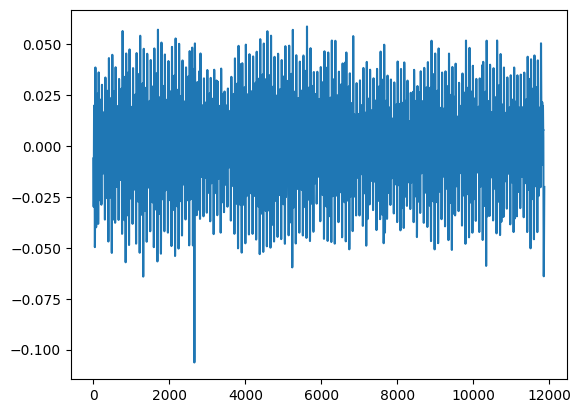

torch.Size([30, 1, 300])


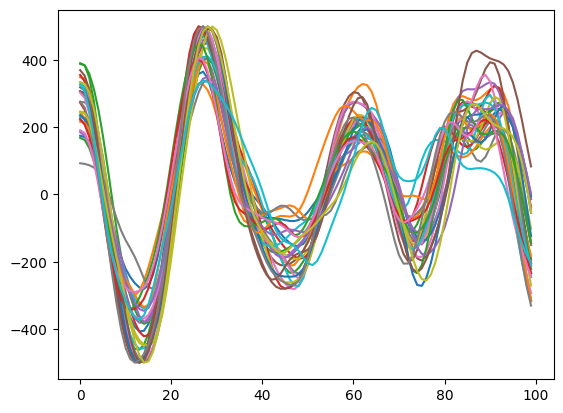

数据保存成功！


In [1]:
from scipy import signal
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import sys  
sys.path.append('/root/zqh/filter_test')
from Toolkit import *
begin = 5000
end = 100000
# data = np.array(pd.read_csv('/root/zqh/BCGOrigin_Data/pa10-bcg.csv'))[begin:end]
data = np.array(pd.read_csv('/root/zqh/BCGOrigin_Data/kansas_bcg1/pa40.csv'))[begin:end, 9:10]
# data = np.array(pd.read_csv('/root/zqh/BCGOrigin_Data/kansas_bcg1/pa16.csv'))[begin:end, 11:12]
save_data_name = '/root/zqh/BandPassDataSet/bandpass_data_pa40.pt'
# data = data.reshape(data.shape[0])
# b, a = signal.butter(4, [0.6*2/125,8*2/125],'bandpass')
# filtedData = signal.filtfilt(b, a, data) #data为filtedData要过滤的信号
data = data.reshape(1,1,end-begin)
data = data.astype(np.float32)
data = torch.tensor(data)
data = avgpool(data=data,stride=8) # Kansas数据预处理
data = bcgFilter(data)
data = torch.tensor(data.copy())
data = data.view(1,1,data.shape[-1])
plt.plot(data[0][0])
plt.show()
Sc2 = data

import GateNet
# 通过斜率划分
# index_list = GateNet.getIndexByGrad(Sc2)
# Save_data = torch.zeros(1,1,300)
# for i in range(index_list.__len__()):
#     Save_data = torch.cat([Save_data, Sc2[:,:,index_list[i]:index_list[i]+300]],dim=0)
# Save_data = Save_data[1:,:,:]
# print(Save_data.shape)
# for i in range(index_list.__len__()):
#     plt.plot(Save_data[i][0][0:100].detach().numpy())
# plt.show()

# 通过三峰相似度划分

grad_index1 = GateNet.read_one_peak(data = Sc2[:,:,:int(Sc2.shape[-1]//2)])
grad_index2 = GateNet.read_one_peak(data = Sc2[:,:,int(Sc2.shape[-1]//2):])

heartbeat_length = 300
pre_split_bcg2 = torch.zeros(1,1,heartbeat_length)
# for i in range(len(grad_index) // 30):
for i in range(len(grad_index1)):
    pre_split_bcg2 = torch.cat([pre_split_bcg2, Sc2[:, :, grad_index1[i].index:grad_index1[i].index + heartbeat_length]],
                              dim=0)
for i in range(len(grad_index2)):
    pre_split_bcg2 = torch.cat([pre_split_bcg2, Sc2[:, :, grad_index2[i].index+int(Sc2.shape[-1]//2):grad_index2[i].index + heartbeat_length+int(Sc2.shape[-1]//2)]],
                              dim=0)
pre_split_bcg2 = pre_split_bcg2[1:, :, :]
pre_split_bcg2 = ones_data(pre_split_bcg2)
pre_split_bcg = pre_split_bcg2


muban = torch.mean(pre_split_bcg2[5:10,:,:],dim=0)
# pre_split_bcg = pre_split_bcg[0:150,:,:]

most_list = []
for i in range(pre_split_bcg.shape[0]):
    key = i
    value = C_similarity(pre_split_bcg[i][0][0:100],muban[:,:100])
    most_list.append([key,value])
most_list = sorted(most_list, key=lambda x: (-x[1], x[0]))

most_list = most_list[:30]
ans_list = []
for i in range(most_list.__len__()):
    ans_list.append(most_list[i][0])
pre_split_bcg = pre_split_bcg[ans_list,:,:]

print(pre_split_bcg.shape)
for i in range(pre_split_bcg.shape[0]):
    plt.plot(pre_split_bcg[i][0][0:100].detach().numpy())
plt.show()

torch.save(pre_split_bcg, save_data_name)
print('数据保存成功！')